In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import *
from models import *
from utils import *

# torch._dynamo.config.suppress_errors = True

Load dataset:

In [2]:
noise_delta_256 = []

In [32]:
data_size = 640_000
data_gen = single_random_ring(N=32)
X, y = data_gen.generate_dataset(data_size=data_size, noise=True, sigma=0.3, features_degree=2, seed=42, device='cpu', test_return=False)
noise_delta_256.append(np.abs(y - y_bis).mean())

In [131]:
np.std(noise_delta_256)

0.000442853695151313

In [58]:
np.abs(y - y_bis).mean()

0.002493890752017239

In [66]:
data_gen.noise_delta, data_gen.noise_delta_true

(0.10209998983895327, 0.09081598759597125)

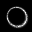

In [24]:
Image.fromarray((y[0] * 255 / y[0].max()).astype(np.uint8))

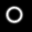

In [57]:
Image.fromarray((y_bis[0] * 255 / y_bis[0].max()).astype(np.uint8))

[[23.         12.          6.72        1.25        4.55530935  0.435     ]
 [18.          9.          7.41        0.88        5.57632696  0.13      ]
 [12.          8.          7.08        1.27        0.35342917  0.105     ]
 ...
 [23.         18.          6.6         1.42        1.13882734  0.4       ]
 [11.         16.          8.76        1.07        2.51327412  0.27      ]
 [16.         19.          6.84        1.48        1.68860605  0.08      ]]
[[0.         1.         0.26666667 ... 0.53225743 0.64112826 0.77226814]
 [0.         0.66666667 0.06666667 ... 0.79759503 0.23454673 0.06897255]
 [0.         0.26666667 0.         ... 0.00320399 0.01200686 0.04499541]
 ...
 [0.         1.         0.66666667 ... 0.03326609 0.14738581 0.65299459]
 [0.         0.2        0.53333333 ... 0.16201891 0.21955403 0.29752066]
 [0.         0.53333333 0.73333333 ... 0.07313793 0.04370752 0.02611978]]


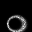

In [8]:
features, transformed_features, imgs = data_gen.random_sample(256)
print(features)
print(transformed_features)
Image.fromarray((imgs[0] * 255 / imgs[0].max()).astype(np.uint8))

Test generator:

In [7]:
dict_blocks = {0:Conv3x3x3NormAct, 1:BottleNeck, 2:LinearBottleNeck, 3:Conv3x11x3NormAct}

arch_dict = {
        'linear_layers':LinearNormAct(6, 8192, 5),
        'scale_up_1_channels':512,
        'unconv_1':BottleNeck(512, 256),
        'scale_up_2_channels':256,
        'unconv_2':Conv3x3x3NormAct(256, 128),
        'scale_up_3_channels':128,
        'unconv_3':Conv3x3x3NormAct(128, 64),
        'scale_up_4_channels':64,
        'unconv_4':torch.nn.Identity()
    }

In [26]:
# load generator
generator = DGBaNConv17()
# generator = torch.compile(generator)

pre_trained_weights = torch.load(
    '../save_data/single_random_ring/Adam_l1_loss_0/DGBaNConv17_no_activation_function/DGBaNConv17_no_activation_function_7.pt',
    map_location=torch.device('cpu')
)
generator.load_state_dict(pre_trained_weights)

print(generator.eval())
print(f'Number of parameters: {count_params(generator):,}')

DGBaNConv17(
  (linear_layers): LinearNormAct(
    (linear_act): ModuleList(
      (0): LinearReparameterization()
      (1): ReLU()
      (2): LinearReparameterization()
      (3): ReLU()
      (4): LinearReparameterization()
      (5): ReLU()
      (6): LinearReparameterization()
      (7): ReLU()
      (8): LinearReparameterization()
      (9): ReLU()
    )
  )
  (conv_layers): BayesSequential(
    (bayes_modules): ModuleList(
      (0): BottleNeck(
        (block): ResidualAdd(
          (block): BayesSequential(
            (bayes_modules): ModuleList(
              (0-1): 2 x ConvNormAct(
                (conv): ConvTranspose2dReparameterization()
                (norm_act): Sequential(
                  (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (1): ReLU()
                )
              )
              (2): ConvNormAct(
                (conv): ConvTranspose2dReparameterization()
                (norm_act): Sequential(

In [27]:
mse_loss = []
l1_loss = []
AbsMeanDelta = []
for i in range(1):
    y_pred = generator(torch.Tensor(transformed_features[:1]))[0].detach().numpy().squeeze()
    mse_loss.append(((y_pred - imgs[0])**2).mean())
    l1_loss.append(abs(y_pred - imgs[0]).mean())
    AbsMeanDelta.append(abs((y_pred - imgs[0]).mean()))

print(np.mean(mse_loss))
print(np.mean(l1_loss))
print(np.mean(AbsMeanDelta))

0.026265253561284802
0.06162003283340386
0.061410251042198175


In [28]:
# setting the base feature
n_samples = 1

# getting the predictions for this feature
pred_rings = np.zeros((n_samples, 32, 32))
with torch.no_grad():
    for j in range(n_samples):
        pred_rings[j] += generator(torch.Tensor(transformed_features[:1]))[0].detach().numpy().squeeze()
pred_ring = pred_rings.mean(axis=0)

# summing the predictions
pred_prob = pred_ring * 255 / pred_ring.max()
true_prob = data_gen.ring_from_features(*features[0]) * 255

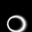

In [29]:
# predicted gaussian ring
Image.fromarray(abs(pred_prob).astype(np.uint8))

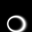

In [30]:
# true gaussian ring
Image.fromarray(true_prob.astype(np.uint8))

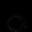

In [31]:
# difference between the rings
Image.fromarray(np.abs(true_prob - pred_prob).astype(np.uint8))

In [46]:
# MSE error
((pred_prob / pred_prob.max() - true_prob / true_prob.max())**2).mean()

0.8984972122322514

NameError: name 'true_prob' is not defined

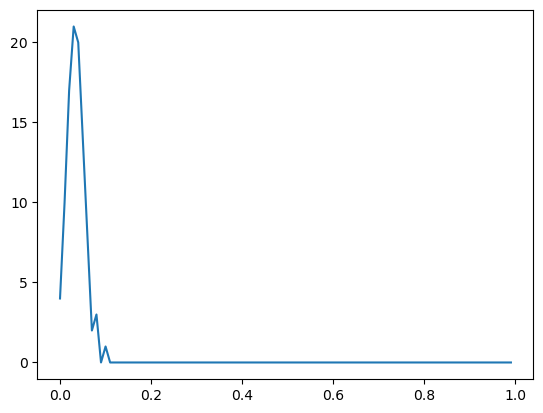

In [12]:
# getting the distribution for one pmt
pmt = (16, 17)
pred = pd.Series(pred_rings[:, pmt[0], pmt[1]])
hist = pd.Series(1, index=pd.cut(pred, np.arange(0, 1.01, 0.01))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * 0.01)

plt.plot(np.arange(0, 1, 0.01), pred_noise)

val = np.arange(0, 2, 0.01) * true_prob[pmt] / (2 * 255)
true_pmt_distr = np.exp(-(val - true_prob[pmt] / (2 * 255))**2 / 0.3**2)
true_pmt_distr /= true_pmt_distr.sum() * 0.01 * true_prob[pmt] / (2 * 255)
plt.plot(val, true_pmt_distr)
plt.show()